In [337]:
garchAutoTryFit = function(
  ll,
  data,
  trace=FALSE,
  forecast.length=1,
  with.forecast=TRUE,
  ic="AIC",
  garch.model="garch" )
{
  formula = as.formula( paste( sep="",
                               "~ arma(", ll$order[1], ",", ll$order[2], ")+",
                               garch.model,
                               "(", ll$order[3], ",", ll$order[4], ")" ) )
  fit = tryCatch( garchFit( formula=formula,
                            data=data,
                            trace=FALSE,
                            cond.dist=ll$dist ),
                  error=function( err ) TRUE,
                  warning=function( warn ) FALSE )
  
  pp = NULL
  
  if( !is.logical( fit ) ) {
    if( with.forecast ) {
      pp = tryCatch( predict( fit,
                              n.ahead=forecast.length,
                              doplot=FALSE ),
                     error=function( err ) FALSE,
                     warning=function( warn ) FALSE )
      if( is.logical( pp ) ) {
        fit = NULL
      }
    }
  } else {
    fit = NULL
  }
  
  if( trace ) {
    if( is.null( fit ) ) {
      cat( paste( sep="",
                  "   Analyzing (", ll$order[1], ",", ll$order[2],
                  ",", ll$order[3], ",", ll$order[4], ") with ",
                  ll$dist, " distribution done.",
                  "Bad model.\n" ) )
    } else {
      if( with.forecast ) {
        cat( paste( sep="",
                    "   Analyzing (", ll$order[1], ",", ll$order[2], ",",
                    ll$order[3], ",", ll$order[4], ") with ",
                    ll$dist, " distribution done.",
                    "Good model. ", ic, " = ", round(fit@fit$ics[[ic]],6),
                    ", forecast: ",
                    paste( collapse=",", round(pp[,1],4) ), "\n" ) )
      } else {
        cat( paste( sep="",
                    "   Analyzing (", ll[1], ",", ll[2], ",", ll[3], ",", ll[4], ") with ",
                    ll$dist, " distribution done.",
                    "Good model. ", ic, " = ", round(fit@fit$ics[[ic]],6), "\n" ) )
      }
    }
  }
  
  return( fit )
}

garchAuto = function(
  xx,
  min.order=c(0,0,1,1),
  max.order=c(5,5,2,2),     # Ставлю лаг в год, ведь экономика - сезонна
  trace=FALSE,
  cond.dists="sged",
  with.forecast=TRUE,
  forecast.length=1,
  arma.sum=c(0,1e9),
  cores=1,
  ic="AIC",
  garch.model="garch" )
{
  require( fGarch )
  require( parallel )
  
  len = NROW( xx )
  
  models = list( )
  
  for( dist in cond.dists )
    for( p in min.order[1]:max.order[1] )
      for( q in min.order[2]:max.order[2] )
        for( r in min.order[3]:max.order[3] )
          for( s in min.order[4]:max.order[4] )
          {
            pq.sum = p + q
            if( pq.sum <= arma.sum[2] && pq.sum >= arma.sum[1] )
            {
              models[[length( models ) + 1]] = list( order=c( p, q, r, s ), dist=dist )
            }
          }
  
  res = mclapply( models,
                  garchAutoTryFit,
                  data=xx,
                  trace=trace,
                  ic=ic,
                  garch.model=garch.model,
                  forecast.length=forecast.length,
                  with.forecast=TRUE,
                  mc.cores=cores )
  
  best.fit = NULL
  
  best.ic = 1e9
  for( rr in res )
  {
    if( !is.null( rr ) )
    {
      current.ic = rr@fit$ics[[ic]]
      if( current.ic < best.ic )
      {
        best.ic = current.ic
        best.fit = rr
      }
    }
  }
  
  if( best.ic < 1e9 )
  {
    return( best.fit )
  }
  
  return( NULL )
    }

In [261]:
library(dplyr)

In [1]:
library(readxl)

Warning message:
"package 'readxl' was built under R version 3.6.3"


In [2]:
library(tseries)

Warning message:
"package 'tseries' was built under R version 3.6.3"
Registered S3 method overwritten by 'quantmod':
  method            from
  as.zoo.data.frame zoo 



In [7]:
library(forecast)

Warning message:
"package 'forecast' was built under R version 3.6.3"


In [611]:
price <- read_excel('price.xlsx')

In [612]:
price <- price[-97,3:4]

In [613]:
price <- as.ts(price)

In [614]:
price <- diff(log(price))

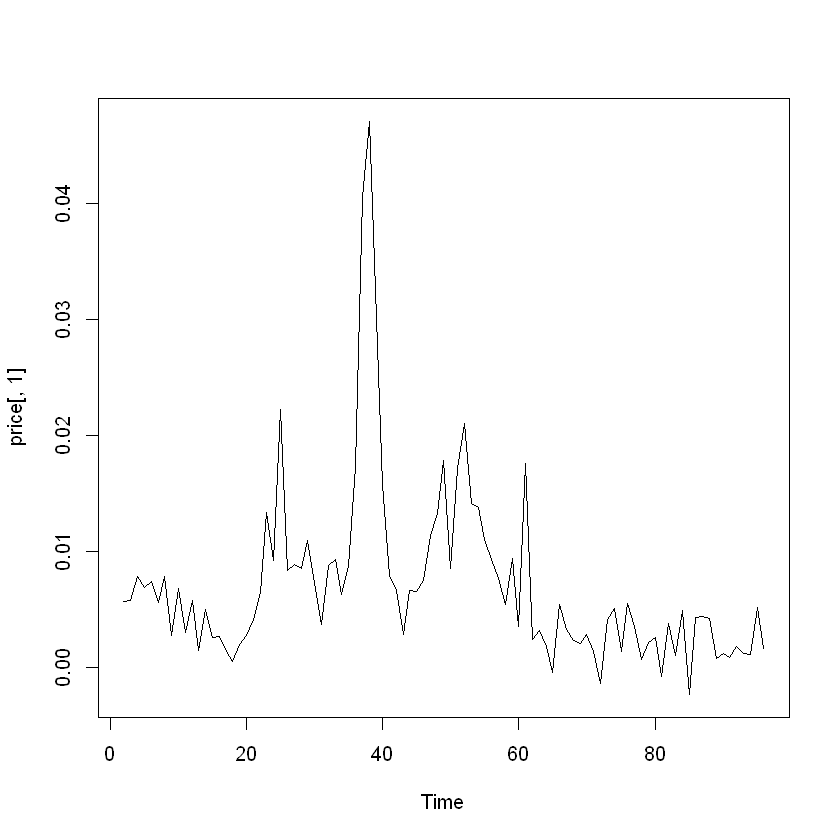

In [615]:
plot(price[,1])

#### Первое что приходит в голову, что может влиять на цену, это инфляция. Подгружу ее отдельным файлом + загружу USD/RUB. В идеале инфляция должна влиять на курс, но в суровом мире макроэкономика эти два показатели часто рассматривают отдельно.

In [253]:
ex <- read_excel('exr.xlsx')

In [254]:
ex <- as.ts(ex)

In [255]:
ex <- diff(log(ex))

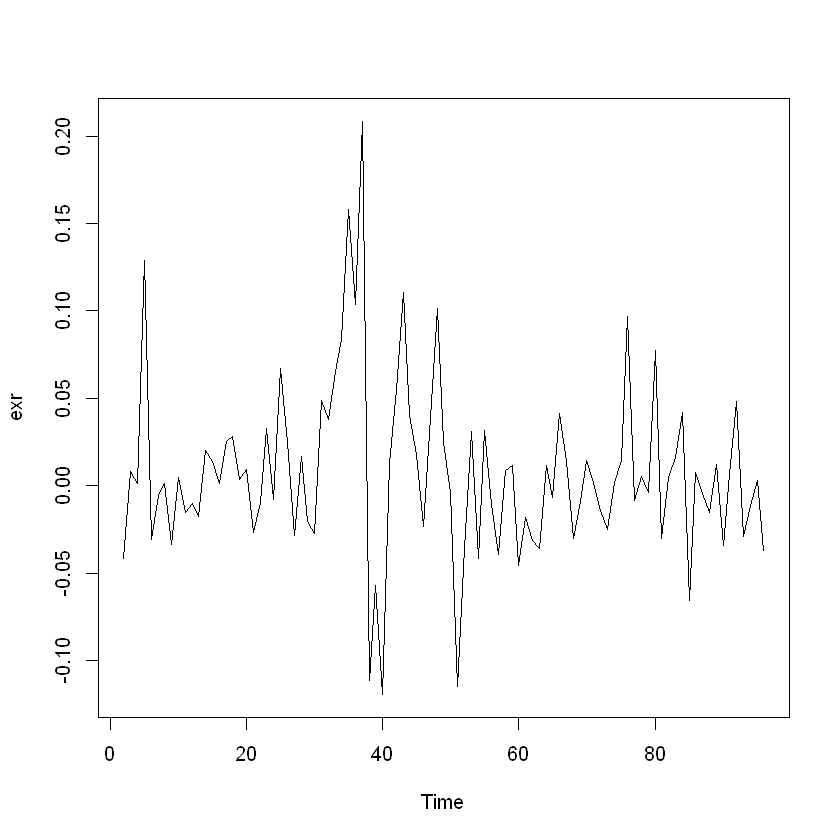

In [256]:
plot(ex, t = 'l')

In [609]:
infl <- read_excel('Infl.xlsx')

In [610]:
infl <- infl[25:120,]

In [153]:
infl <- as.ts(infl)

In [154]:
infl <- infl[-1]

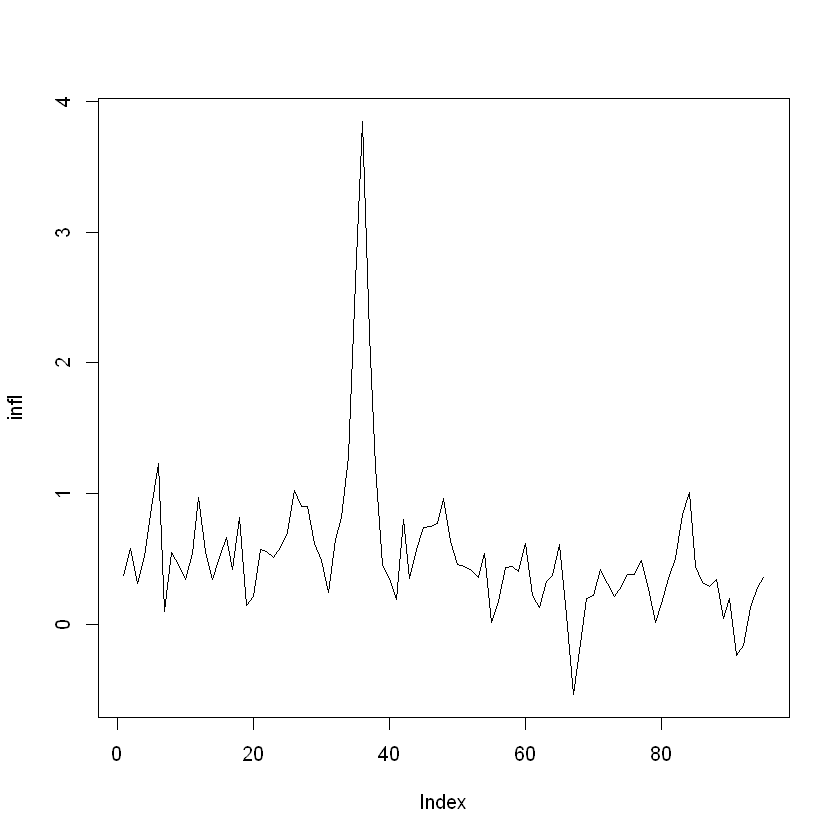

In [155]:
plot(infl, t = 'l')

#### Связь с инфляцией на лицо, попробую построить линейную регрессию, но сначала, как всегда, нужно проверить на стационарность 

In [156]:
adf.test(price[,2])

Warning message in adf.test(price[, 2]):
"p-value smaller than printed p-value"



	Augmented Dickey-Fuller Test

data:  price[, 2]
Dickey-Fuller = -4.1551, Lag order = 4, p-value = 0.01
alternative hypothesis: stationary


In [157]:
library(vars)

In [158]:
m1 <- VAR(price, lag.max = 12)

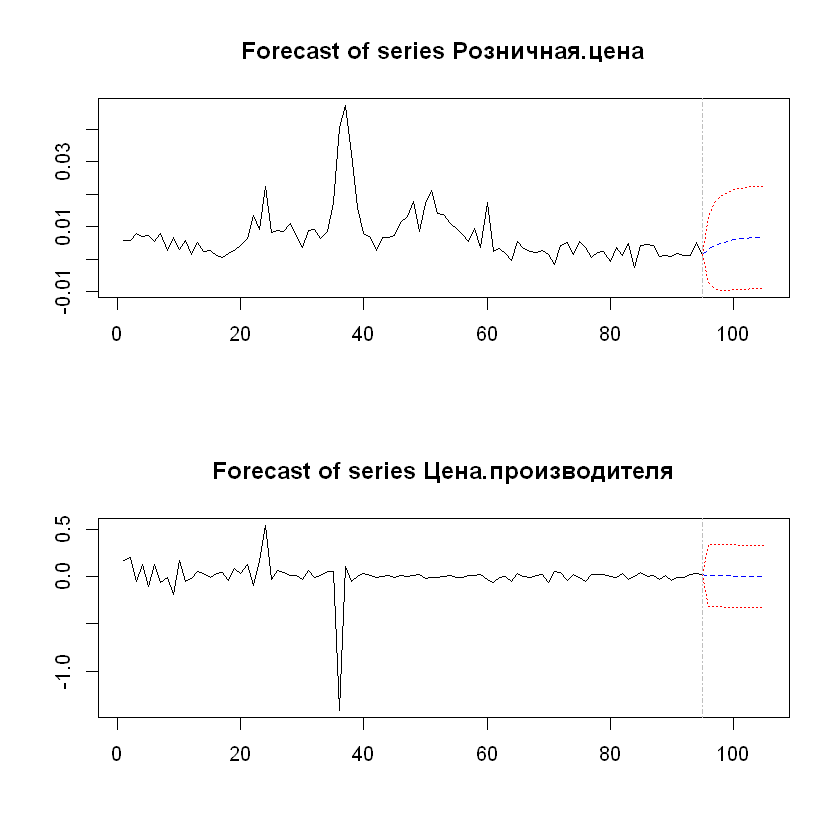

In [161]:
plot(predict(m1))

#### Думаю, что все-таки цена производителя влияет на розничную, нежели наоборот. Поэтому сначала будет построен прогноз для цен производителя, потом же, исходя из прогноза, буду прогнозировать розничую цену 

In [162]:
summary(m1) # Модель, кстати, тоже показала, что именно производитель "диктует правила"


VAR Estimation Results:
Endogenous variables: Розничная.цена, Цена.производителя 
Deterministic variables: const 
Sample size: 94 
Log Likelihood: 407.714 
Roots of the characteristic polynomial:
0.7223 0.1659
Call:
VAR(y = price, lag.max = 12)


Estimation results for equation Розничная.цена: 
Розничная.цена = Розничная.цена.l1 + Цена.производителя.l1 + const 

                        Estimate Std. Error t value Pr(>|t|)    
Розничная.цена.l1      0.6951317  0.0718504   9.675 1.22e-15 ***
Цена.производителя.l1 -0.0076765  0.0033808  -2.271  0.02553 *  
const                  0.0021420  0.0007422   2.886  0.00487 ** 
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1


Residual standard error: 0.005188 on 91 degrees of freedom
Multiple R-Squared: 0.5769,	Adjusted R-squared: 0.5676 
F-statistic: 62.04 on 2 and 91 DF,  p-value: < 2.2e-16 


Estimation results for equation Цена.производителя: 
Цена.производителя = Розничная.цена.l1 + Цена.производителя.l1 + const 

      

#### Осталось понять, что влияет на цены для произодителей

In [313]:
data <- cbind(as.data.frame(price[,2]), as.data.frame(infl), as.data.frame(ex))

In [314]:
colnames(data)[1] <- 'prod_price'

In [315]:
colnames(data)[3] <- 'exr'

In [316]:
data$prod_price <- as.numeric(data$prod_price)

In [317]:
data$infl.l1 <- lag(data$infl)

In [318]:
data$infl.l12 <- lag(data$infl, 12)

In [319]:
data$price_prod.l1 <- lag(data$prod_price)

In [320]:
data$price_prod.l12 <- lag(data$prod_price, 12)

In [321]:
data$exr.l1 <- lag(data$exr)

In [322]:
data$exr.l12 <- lag(data$exr, 12)

In [323]:
data <- data[-c(1:12),]

In [342]:
tail(data)

,prod_price,infl,price_prod.l1,price_prod.l12
,<dbl>,<dbl>,<dbl>,<dbl>
90,-0.039352250,0.20,0.008110151,0.020378728
91,-0.007514865,-0.24,-0.039352250,0.015730832
92,-0.015436774,-0.16,-0.007514865,0.003791035
93,0.019506971,0.13,-0.015436774,-0.006120439
94,0.029286369,0.28,0.019506971,0.033013838
95,0.022437404,0.36,0.029286369,-0.030623728


#### Ничего лучше линейной регрессии не придумал 

In [324]:
m3 <- lm(prod_price ~., data = data)

In [325]:
summary(m3)


Call:
lm(formula = prod_price ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.71176 -0.04792 -0.00291  0.04754  0.56306 

Coefficients:
                Estimate Std. Error t value Pr(>|t|)   
(Intercept)     0.070619   0.026133   2.702  0.00853 **
infl           -0.170358   0.053579  -3.180  0.00215 **
exr            -0.190547   0.390211  -0.488  0.62677   
infl.l1         0.007429   0.053705   0.138  0.89036   
infl.l12        0.027453   0.037895   0.724  0.47107   
price_prod.l1  -0.149838   0.126798  -1.182  0.24110   
price_prod.l12 -0.186768   0.118948  -1.570  0.12064   
exr.l1          0.229170   0.377093   0.608  0.54523   
exr.l12        -0.404261   0.335936  -1.203  0.23266   
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1399 on 74 degrees of freedom
Multiple R-squared:  0.4006,	Adjusted R-squared:  0.3358 
F-statistic: 6.182 on 8 and 74 DF,  p-value: 4.274e-06


In [329]:
data$infl.l1 <- NULL
data$exr.l1 <- NULL
data$exr <- NULL
data$infl.l12 <- NULL
data$exr.l12 <- NULL

In [330]:
m4 <- lm(prod_price ~., data = data)

In [331]:
summary(m4)


Call:
lm(formula = prod_price ~ ., data = data)

Residuals:
     Min       1Q   Median       3Q      Max 
-0.74375 -0.04637 -0.00362  0.04055  0.57678 

Coefficients:
               Estimate Std. Error t value Pr(>|t|)    
(Intercept)     0.08302    0.02095   3.963 0.000162 ***
infl           -0.16393    0.02797  -5.862 1.01e-07 ***
price_prod.l1  -0.19481    0.09151  -2.129 0.036385 *  
price_prod.l12 -0.20604    0.08748  -2.355 0.020985 *  
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 0.1376 on 79 degrees of freedom
Multiple R-squared:  0.3811,	Adjusted R-squared:  0.3576 
F-statistic: 16.22 on 3 and 79 DF,  p-value: 2.645e-08


#### Курс, как оказалось, совсем не влияет на цены, что странно

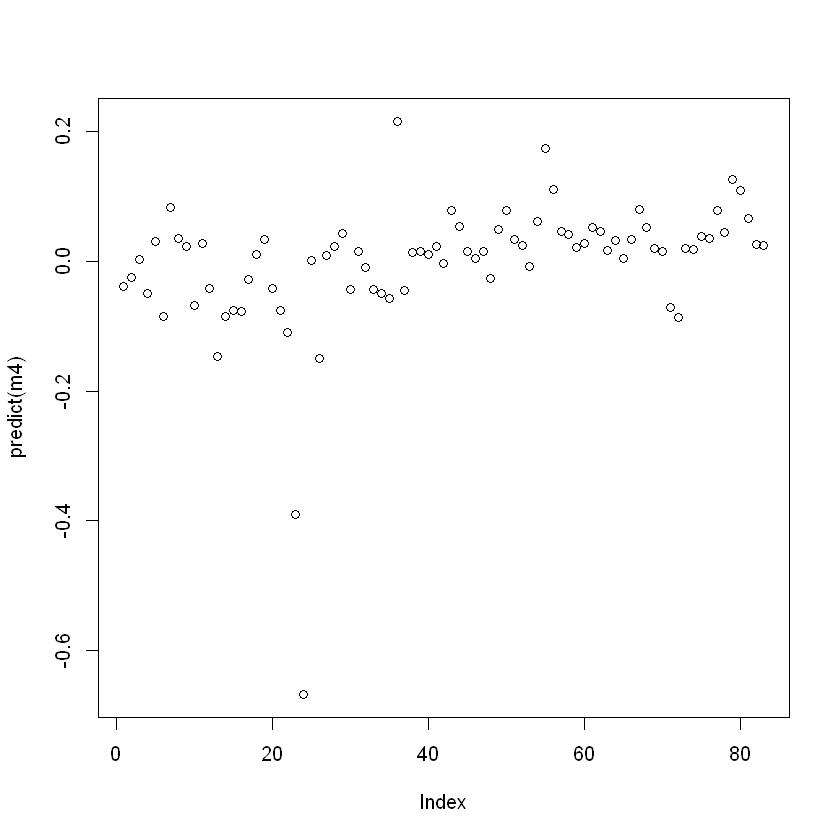

In [333]:
plot(predict(m4))

In [334]:
data

,prod_price,infl,price_prod.l1,price_prod.l12
,<dbl>,<dbl>,<dbl>,<dbl>
13,0.051206376,0.56,-0.020593462,0.164454163
14,0.033363413,0.34,0.051206376,0.200267499
15,-0.006522789,0.51,0.033363413,-0.049063189
16,0.027677339,0.66,-0.006522789,0.126425345
17,0.037952592,0.42,0.027677339,-0.108809161
18,-0.047396291,0.82,0.037952592,0.124756951
19,0.079528498,0.14,-0.047396291,-0.067167887
20,0.030898904,0.21,0.079528498,-0.008748100
21,0.124283937,0.57,0.030898904,-0.190737743


#### Без прогноза по инфляции ничего не получится, ну ладно, сделаем сами 

In [338]:
m1 <- garchAuto(infl)

Loading required package: fGarch

Warning message:
"package 'fGarch' was built under R version 3.6.3"
Loading required package: timeDate

Loading required package: timeSeries

Warning message:
"package 'timeSeries' was built under R version 3.6.3"

Attaching package: 'timeSeries'


The following object is masked from 'package:zoo':

    time<-


Loading required package: fBasics

Warning message:
"package 'fBasics' was built under R version 3.6.3"
Loading required package: parallel



In [339]:
summary(m1)


Title:
 GARCH Modelling 

Call:
 garchFit(formula = formula, data = data, cond.dist = ll$dist, 
    trace = FALSE) 

Mean and Variance Equation:
 data ~ arma(1, 5) + garch(2, 1)
<environment: 0x000000000908b408>
 [data = data]

Conditional Distribution:
 sged 

Coefficient(s):
         mu          ar1          ma1          ma2          ma3          ma4  
 0.41059591   0.05836679   0.54154026   0.24770919   0.10097378   0.03362120  
        ma5        omega       alpha1       alpha2        beta1         skew  
-0.13167851   0.03499315   0.74163495   0.00000001   0.00000001   1.01213803  
      shape  
 1.00000000  

Std. Errors:
 based on Hessian 

Error Analysis:
         Estimate  Std. Error  t value Pr(>|t|)    
mu      4.106e-01   1.053e-02   39.004  < 2e-16 ***
ar1     5.837e-02   1.728e-02    3.377 0.000733 ***
ma1     5.415e-01   1.364e-02   39.716  < 2e-16 ***
ma2     2.477e-01   1.354e-02   18.292  < 2e-16 ***
ma3     1.010e-01   1.070e-02    9.438  < 2e-16 ***
ma4     3.362e-

In [341]:
infl_pred <- predict(m1, n.ahead = 12)[,1]

In [344]:
data[83,1]

[1] 0.0224374

In [376]:
pred_prod_price <- NULL
pred_prod_price <- as.data.frame(pred_prod_price)

In [380]:
for (i in 1:12) {
newdata <- cbind(predict(m1, n.ahead = 12)[i,1], data[(82+i),1], data[(71+i),1])
newdata <- as.data.frame(newdata)
colnames(newdata) <- c('infl', 'price_prod.l1', 'price_prod.l12')
newdata <- cbind(as.data.frame(predict(m4, newdata = newdata)), newdata)
colnames(newdata)[1] <- 'prod_price'
data <- rbind(data, newdata)
}

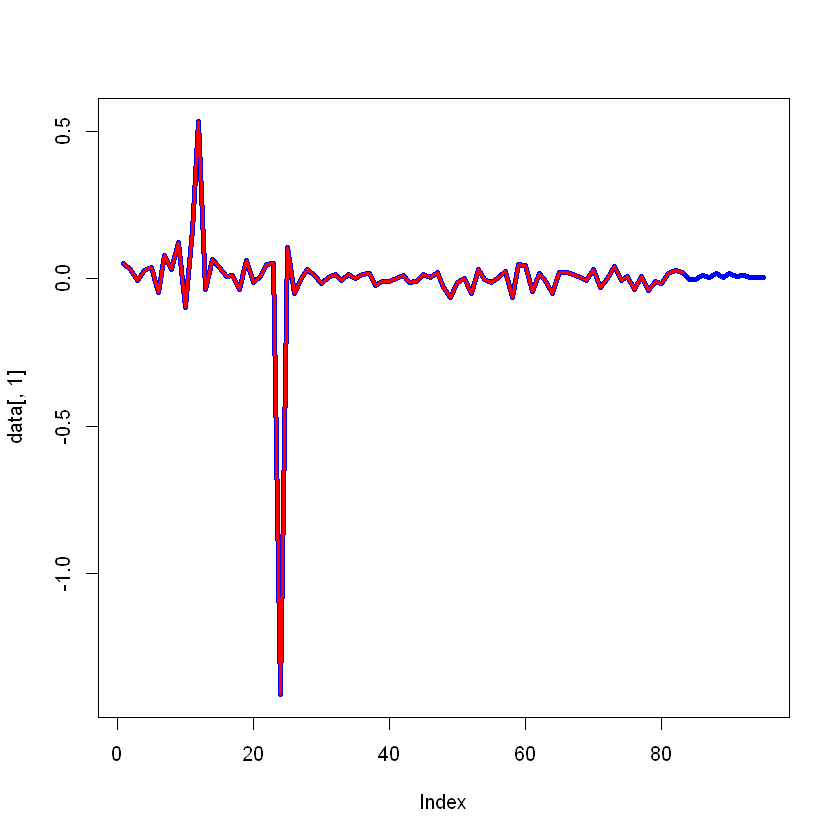

In [381]:
plot(data[,1], t='l', col = 'blue', lwd = 4)
lines(data[1:83,1], col = 'red', lwd = 3)

In [391]:
first <- read_excel('price.xlsx')

In [392]:
first <- first[1,3:4]

In [616]:
price <- as.data.frame(price)

In [617]:
price$roz1 <- lag(price$`Розничная цена`)

In [618]:
head(price)

,Розничная цена,Цена производителя,roz1
,<dbl>,<dbl>,<dbl>
1,0.005704898,0.16445416,0.005704898
2,0.005781309,0.20026750,0.005781309
3,0.007800690,-0.04906319,0.007800690
4,0.006883228,0.12642534,0.006883228
5,0.007368286,-0.10880916,0.007368286
6,0.005623059,0.12475695,0.005623059


In [619]:
m6 <- lm(price$`Розничная цена` ~., data = price)

In [620]:
summary(m6)

Warning message in summary.lm(m6):
"essentially perfect fit: summary may be unreliable"



Call:
lm(formula = price$`Розничная цена` ~ ., data = price)

Residuals:
       Min         1Q     Median         3Q        Max 
-1.016e-18 -1.549e-19 -2.267e-20  1.043e-19  2.142e-18 

Coefficients:
                      Estimate Std. Error   t value Pr(>|t|)    
(Intercept)          0.000e+00  5.666e-20 0.000e+00        1    
`Цена производителя` 0.000e+00  2.600e-19 0.000e+00        1    
roz1                 1.000e+00  5.512e-18 1.814e+17   <2e-16 ***
---
Signif. codes:  0 '***' 0.001 '**' 0.01 '*' 0.05 '.' 0.1 ' ' 1

Residual standard error: 3.991e-19 on 92 degrees of freedom
Multiple R-squared:      1,	Adjusted R-squared:      1 
F-statistic: 1.818e+34 on 2 and 92 DF,  p-value: < 2.2e-16


In [621]:
newdata2 <- cbind(0, data[(83+k),2],price[93+k,3])
newdata2 <- as.data.frame(newdata2)
colnames(newdata2) <- c('Розничная цена', 'Цена производителя','roz1')

In [622]:
for (k in 1:12) {
newdata2 <- cbind(predict(m6, newdata2), data[(83+k),2],price[93+k,3])
newdata2 <- as.data.frame(newdata2)
colnames(newdata2) <- c('Розничная цена', 'Цена производителя','roz1')
price <- rbind(price, newdata2)
price[94+k,1] <- predict(m6, newdata2)
    }

In [623]:
price

,Розничная цена,Цена производителя,roz1
,<dbl>,<dbl>,<dbl>
1,0.0057048975,0.164454163,0.0057048975
2,0.0057813087,0.200267499,0.0057813087
3,0.0078006896,-0.049063189,0.0078006896
4,0.0068832279,0.126425345,0.0068832279
5,0.0073682858,-0.108809161,0.0073682858
6,0.0056230587,0.124756951,0.0056230587
7,0.0077985431,-0.067167887,0.0077985431
8,0.0027256543,-0.008748100,0.0027256543
9,0.0067818091,-0.190737743,0.0067818091


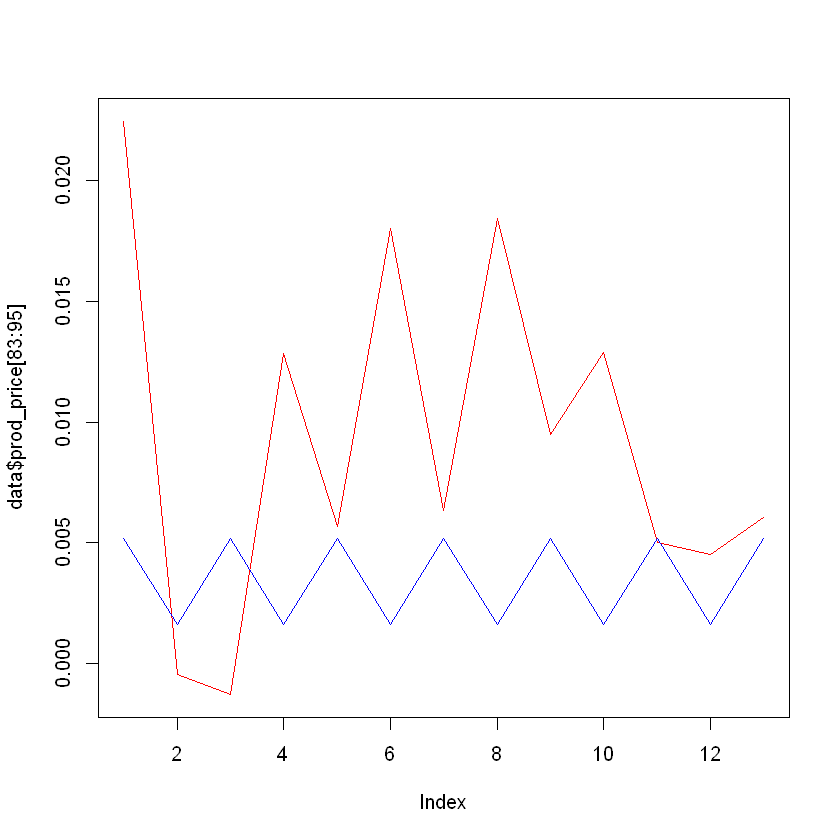

In [624]:
plot(data$prod_price[83:95], t ='l', col = 'red')
lines(price[95:107,1], col = 'blue')

In [625]:
prognoz <- cbind(data$prod_price[84:95], price[96:107,1])
colnames(prognoz) <- c('Розничная цена', 'Цена производителя')

In [636]:
price1 <- read_excel('price.xlsx')

In [637]:
price1 <- price1[97,3:4]

In [638]:
price1

Розничная цена,Цена производителя
<dbl>,<dbl>
181.13,25142.47


In [639]:
prognoz

Розничная цена,Цена производителя
-0.0004531553,0.001628619
-0.0012720371,0.005184278
0.0128558164,0.001628619
0.0056706020,0.005184278
0.0180043989,0.001628619
0.0063636674,0.005184278
0.0184123840,0.001628619
0.0095056408,0.005184278
0.0128729643,0.001628619
0.0050172954,0.005184278


In [640]:
price1 <- rbind(price1, prognoz)

In [642]:
for (i in 2:13) {
price1[i,1] <- price1[(i-1),1]*exp(price1[i,1])
price1[i,2] <- price1[(i-1),2]*exp(price1[i,2])
}

In [643]:
price1

Розничная цена,Цена производителя
<dbl>,<dbl>
181.1300,25142.47
181.0479,25183.45
180.8178,25314.35
183.1574,25355.61
184.1989,25487.40
187.5453,25528.94
188.7426,25661.64
192.2500,25703.46
194.0862,25837.06


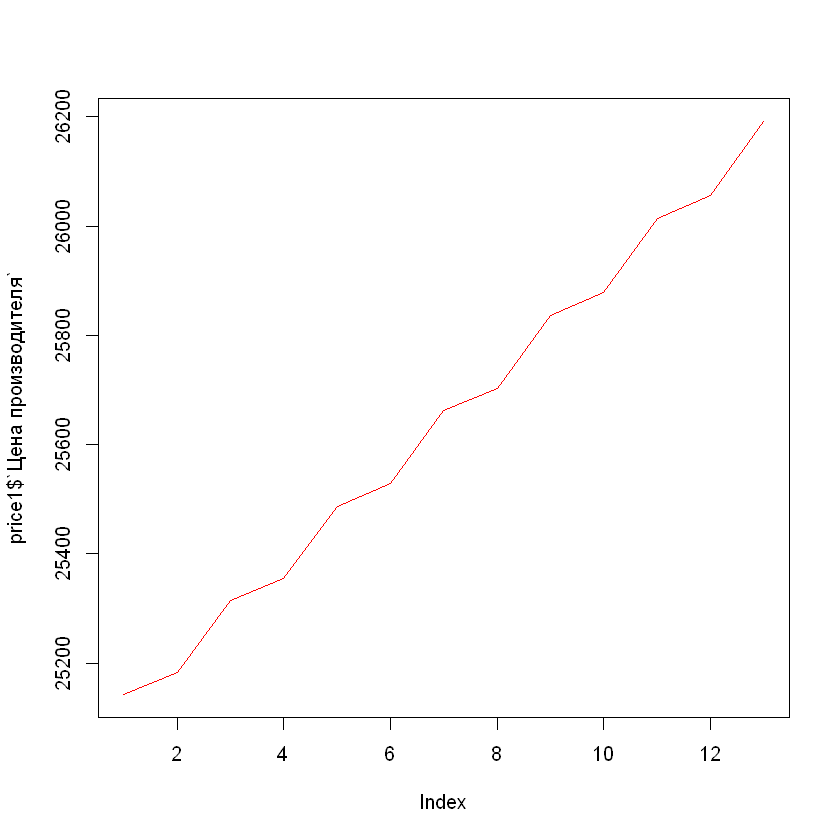

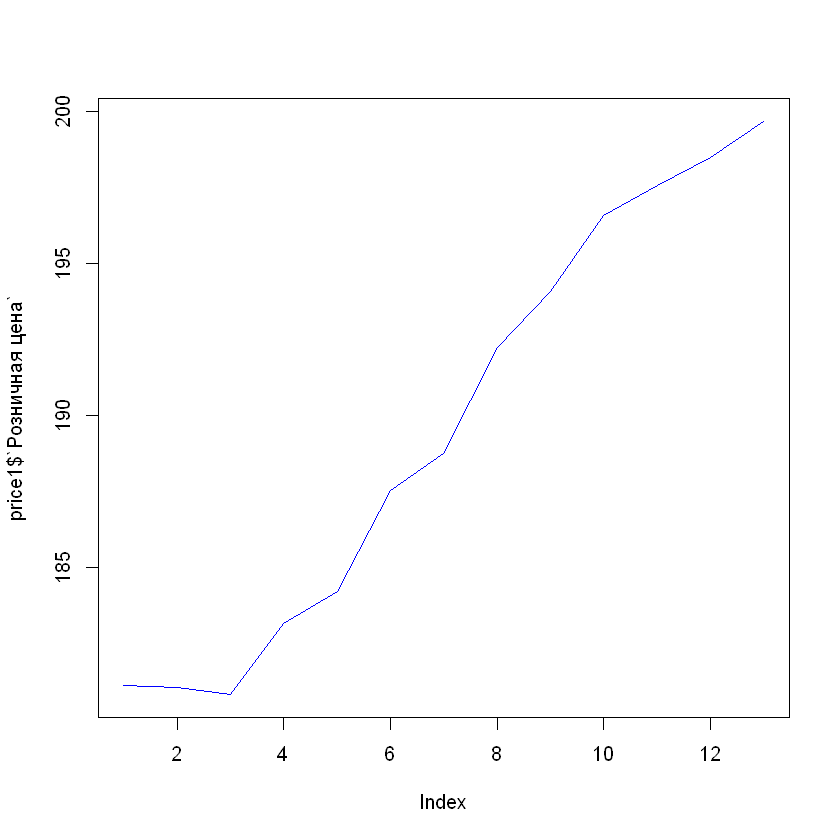

In [650]:
plot(price1$`Цена производителя`, t = 'l', col = 'red')
plot(price1$`Розничная цена`, t ='l', col = 'blue')

#### В итоге получили прогноз розничной цены кетчупа, который составлен на основе прогноза цены производителя, которая, в свою очередь, составлена на основе прогноза инфляции, потому что месячные прогнозные данные по ней не найти. 